In [ ]:
# Installing Dependencies
!pip install transformers datasets torch scikit-learn matplotlib pandas --quiet

In [ ]:
# Importing Libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Using GPU if Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
# Loading Pretrained Model and Tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Loading SST-2 Validation Dataset for Demo
dataset = load_dataset("glue", "sst2", split="validation")
dataset = dataset.rename_column("sentence", "text")
print(dataset)

Dataset({
    features: ['text', 'label', 'idx'],
    num_rows: 872
})


In [ ]:
# Prediction function
def predict_batch(texts, tokenizer, model, device):
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**encodings)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
        preds = probs.argmax(axis=1)
    return preds, probs

In [ ]:
# Running Predictions (Limiting to 200 Samples for Quick Run)
texts = dataset["text"]
labels = dataset["label"]
preds, probs = predict_batch(texts[:200], tokenizer, model, device)

In [ ]:
# Evaluation
print("Accuracy:", accuracy_score(labels[:200], preds))
print("\nClassification Report:\n", classification_report(labels[:200], preds))
cm = confusion_matrix(labels[:200], preds)
print("Confusion Matrix:\n", cm)

Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91       101
           1       0.87      0.96      0.91        99

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200

Confusion Matrix:
 [[87 14]
 [ 4 95]]


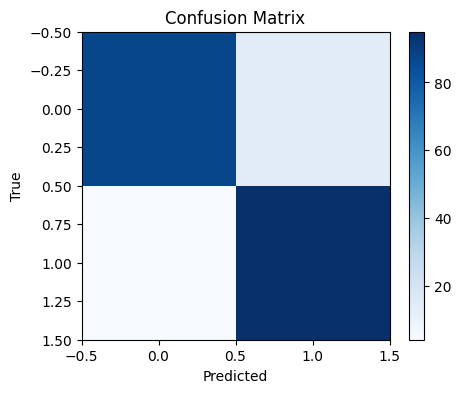

In [ ]:
# Confusion Matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

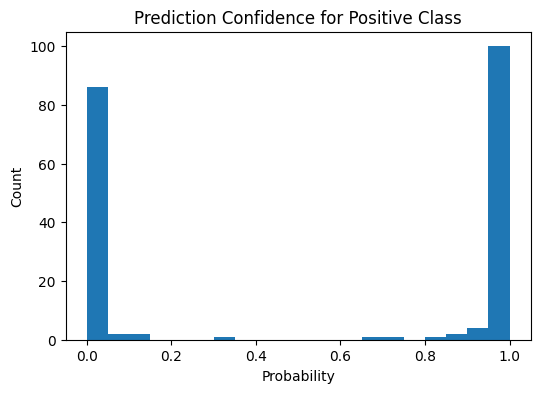

In [ ]:
# Confidence Histogram (For Positive Class)
plt.figure(figsize=(6,4))
plt.hist(probs[:,1], bins=20)
plt.title("Prediction Confidence for Positive Class")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

In [ ]:
# Testing with own Sentence
def predict_text(text, tokenizer, model, device):
    enc = tokenizer([text], truncation=True, padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**enc)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    pred = probs.argmax()
    return pred, probs

In [ ]:
# Trying own Input
user_text = input("Enter a sentence to analyze: ")
pred, probs = predict_text(user_text, tokenizer, model, device)

Enter a sentence to analyze: This is the worst service I have ever received.


In [ ]:
# Formating
labels_map = {0: "Negative", 1: "Positive"}
confidence = probs[pred] * 100
print(f"Text: {user_text}")
print(f"Prediction: {labels_map[pred]} ({confidence:.2f}%)")

Text: This is the worst service I have ever received.
Prediction: Negative (99.98%)
